Based on this:  

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

In [25]:
!pip install tensorflow==1.15.2
!pip install keras

  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)


In [26]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [27]:
df = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', delimiter='\t')
df.shape

(101836, 15)

In [28]:
df_cleaned_and_filtered = df.dropna()
df_cleaned_and_filtered = df_cleaned_and_filtered.reset_index()
df_cleaned_and_filtered.shape

(101831, 16)

In [29]:
df_cleaned_and_filtered['is_positive_sentiment'] = (df_cleaned_and_filtered['star_rating'] >= 4).astype(int)
df_cleaned_and_filtered = df_cleaned_and_filtered[['review_body', 'is_positive_sentiment']]
df_cleaned_and_filtered.head(5)

,review_body,is_positive_sentiment
0,So far so good,1
1,Needs a little more work.....,0
2,Please cancel.,0
3,Works as Expected!,1
4,I've had Webroot for a few years. It expired a...,1


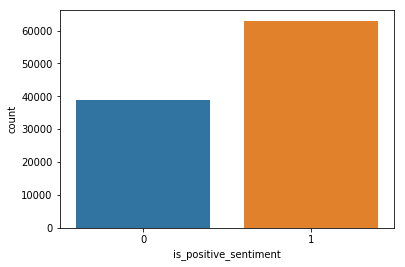

In [30]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


In [31]:
from sklearn.utils import resample

is_negative_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 0')

is_positive_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 1')
print(len(is_negative_sentiment_df))

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                replace = False, # sample without replacement
                                n_samples = len(is_negative_sentiment_df), # match minority n
                                random_state = 27) # reproducible results

df_cleaned_and_filtered_and_balanced = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])
#df_cleaned_and_filtered_and_balanced.head(5)


38876


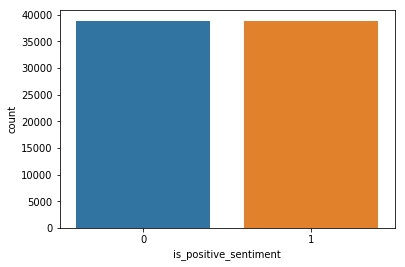

In [32]:
sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered_and_balanced)


In [33]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [34]:
import tensorflow as tf
print("Version: ", tf.__version__)

Version:  1.15.2


In [35]:
# TODO:  Convert this to TF 2.0 tf.keras
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [36]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [37]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [38]:
X = []
sentences = list(df_cleaned_and_filtered['review_body'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [39]:
y = df_cleaned_and_filtered['is_positive_sentiment']
y.head(10)
y.shape

(101831,)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [43]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-03-31 06:49:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-31 06:49:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-31 06:49:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [44]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [45]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [46]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [47]:
#!pip install bert-for-tf2


In [48]:
#import tensorflow_hub as hub

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
#embedding_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
#                            trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3983000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 3,993,001
Trainable params: 10,001
Non-trainable params: 3,983,000
_________________________________________________________________
None


In [50]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)



Train on 65171 samples, validate on 16293 samples
Epoch 1/6
65171/65171 [==============================] - 2s 34us/step - loss: 0.5218 - acc: 0.7423 - val_loss: 0.4806 - val_acc: 0.7700
Epoch 2/6
65171/65171 [==============================] - 2s 29us/step - loss: 0.4436 - acc: 0.7921 - val_loss: 0.4788 - val_acc: 0.7629
Epoch 3/6
65171/65171 [==============================] - 2s 29us/step - loss: 0.4201 - acc: 0.8088 - val_loss: 0.4598 - val_acc: 0.7859
Epoch 4/6
65171/65171 [==============================] - 2s 29us/step - loss: 0.4072 - acc: 0.8176 - val_loss: 0.4629 - val_acc: 0.7876
Epoch 5/6
65171/65171 [==============================] - 2s 27us/step - loss: 0.3977 - acc: 0.8227 - val_loss: 0.4983 - val_acc: 0.7816
Epoch 6/6
65171/65171 [==============================] - 2s 28us/step - loss: 0.3898 - acc: 0.8267 - val_loss: 0.4662 - val_acc: 0.7897


In [51]:
score = model.evaluate(X_test, y_test, verbose=1)


20367/20367 [==============================] - 1s 41us/step


In [52]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4746249426111836
Test Accuracy: 0.7840133309364319


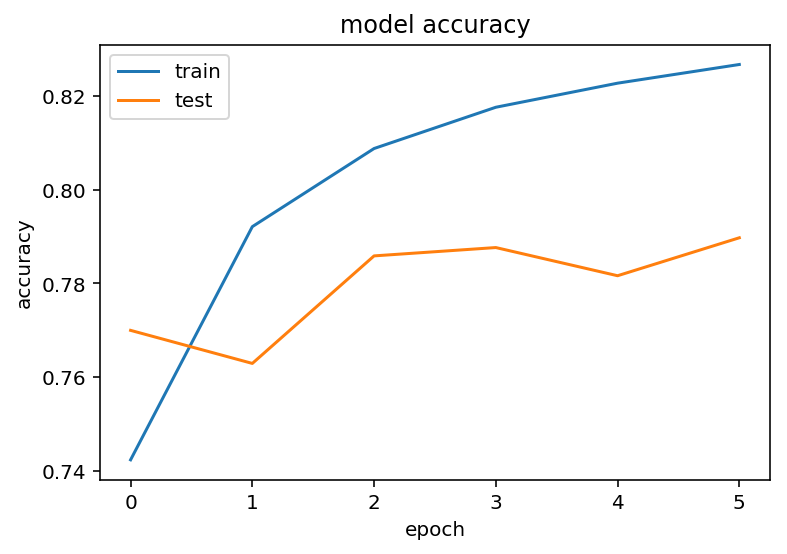

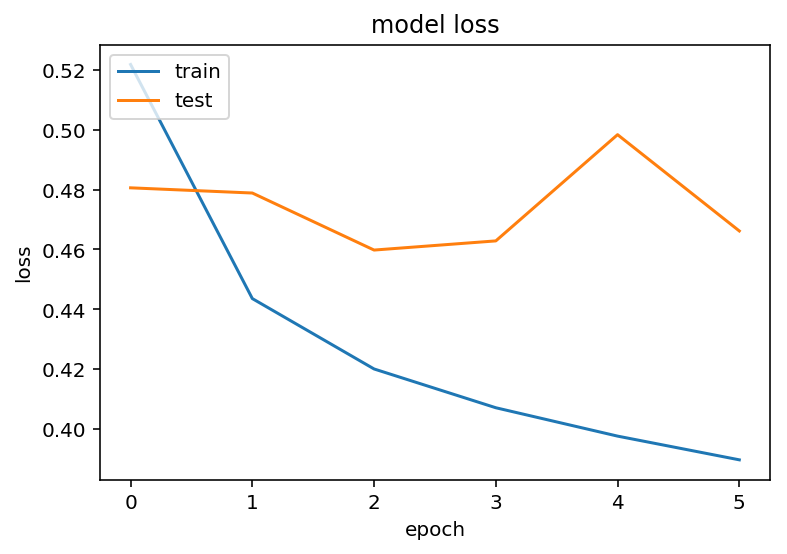

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
         
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [61]:
instance = X[19724]
print(instance)

print(y[19724])


only had problems with updating my downloads otherwise was very easy 
1


In [55]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)


array([[0.00236707]], dtype=float32)

In [56]:
sample_review_body = 'This product sucks!'
instance = tokenizer.texts_to_sequences(sample_review_body)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)


array([[0.13348608]], dtype=float32)

In [62]:
sample_review_body = 'Highly recommended.  This product is great!!'
instance = tokenizer.texts_to_sequences(sample_review_body)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)


array([[0.00443701]], dtype=float32)